In [47]:
import os

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import cv2

current_directory = os.getcwd()

## Load ScanNet scene

In [49]:
scan = "scene0000_00"

scan_path = os.path.join(current_directory, "data/scans", scan)
scene_mesh_path = os.path.join(scan_path, scan + "_vh_clean_2.ply")
scene_mesh = o3d.io.read_triangle_mesh(scene_mesh_path )
segmentation_mesh_path = os.path.join(scan_path, scan + "_vh_clean_2.labels.ply")
segmentation_mesh = o3d.io.read_triangle_mesh(segmentation_mesh_path)

# o3d.visualization.draw_geometries([scene_mesh])

## Select an object

In [50]:
object_id = 4 # Bed 

object_colors_array = [
    (0, 0, 0),             
    (174, 199, 232),        # Wall
    (152, 223, 138),        # Floor
    (31, 119, 180),         # Cabinet
    (255, 187, 120),        # Bed
    (188, 189, 34),         # Chair
    (140, 86, 75),          # Sofa
    (255, 152, 150),        # Table
    (214, 39, 40),          # Door
    (197, 176, 213),        # Window
    (148, 103, 189),        # Bookshelf
    (196, 156, 148),        # Picture
    (23, 190, 207),         # Counter
    (178, 76, 76),          # Blinds
    (247, 182, 210),        # Desk
    (66, 188, 102),         # Shelves
    (219, 219, 141),        # Curtain
    (140, 57, 197),         # Dresser
    (202, 185, 52),         # Pillow
    (51, 176, 203),         # Mirror
    (200, 54, 131),         # Floor mat
    (92, 193, 61),          # Clothes
    (78, 71, 183),          # Ceiling
    (172, 114, 82),         # Books
    (255, 127, 14),         # Fridge
    (91, 163, 138),         # TV
    (153, 98, 156),         # Paper
    (140, 153, 101),        # Towel
    (158, 218, 229),        # Shower curtain
    (100, 125, 154),        # Box
    (178, 127, 135),        # Whiteboard
    (120, 185, 128),        # Person
    (146, 111, 194),        # Nightstand
    (44, 160, 44),          # Toilet
    (112, 128, 144),        # Sink
    (96, 207, 209),         # Lamp
    (227, 119, 194),        # Bathtub
    (213, 92, 176),         # Bag
    (94, 106, 211),         # Other structure
    (100, 85, 144),         # Other furniture
    (82, 84, 163),          # Other prop
]

object_color = np.array(object_colors_array[object_id])

is_object = np.all(np.isclose(segmentation_mesh.vertex_colors, object_color / 255.0), axis=1)
object_vertex_indices = np.where(is_object)[0]
object_vertex_indices_set = set(object_vertex_indices)

faces = np.asarray(scene_mesh.triangles)
face_mask = np.all(np.isin(faces, object_vertex_indices), axis=1)

object_faces = faces[face_mask]
object_vertices = np.asarray(scene_mesh.vertices)[object_vertex_indices]

vertex_remap = {old_idx: new_idx for new_idx, old_idx in enumerate(object_vertex_indices)}
object_faces_remap = np.vectorize(vertex_remap.get)(object_faces)

object_mesh = o3d.geometry.TriangleMesh()
object_mesh.vertices = o3d.utility.Vector3dVector(object_vertices)
object_mesh.triangles = o3d.utility.Vector3iVector(object_faces_remap)
object_mesh.compute_vertex_normals()
object_mesh.vertex_colors = o3d.utility.Vector3dVector(np.asarray(scene_mesh.vertex_colors)[object_vertex_indices])

# o3d.visualization.draw_geometries([object_mesh])

## Project into Camera Images

### Export camera parameters

In [51]:
reader_directory = os.path.join(current_directory, "scripts/SensReader")
sens_file = os.path.join(scan_path, scan + ".sens")
output_directory = os.path.join(current_directory, "outputs/reader/"+scan)

os.system(f"python {os.path.join(reader_directory, 'reader.py')} --filename {sens_file} --output_path {output_directory} --export_poses --export_intrinsics")

Namespace(filename='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens', output_path='/Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00', export_depth_images=False, export_color_images=False, export_poses=True, export_intrinsics=True)
loading /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/data/scans/scene0000_00/scene0000_00.sens...loaded!
exporting 5578 camera poses to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/pose
exporting camera intrinsics to /Users/lara/Desktop/Making-CLIP-features-multiview-consistent/outputs/reader/scene0000_00/intrinsic


0

### Get camera parameters of a given frame

In [52]:
frame = 975

pose = np.loadtxt(os.path.join(output_directory, "pose", str(frame)+".txt"))  # Camera poses
intrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "intrinsic_color.txt"))  # Camera intrinsics
extrinsics = np.loadtxt(os.path.join(output_directory, "intrinsic", "extrinsic_color.txt"))  # Camera estrinsic

### Project 3D vertices to 2D image space

In [53]:
def project_points(points_3d, intrinsic, extrinsic):
    # Add ones to 3D points to make them homogeneous for the extrinsic transformation
    points_3d_homogeneous = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])
    # Transform points to camera coordinates using the extrinsic parameters
    points_camera = np.dot(extrinsic, points_3d_homogeneous.T).T
    # Extract only the x, y, z components because the intrinsic matrix is 3x3
    points_camera_xyz = points_camera[:, :3]
    # Project points onto the image plane using the intrinsic parameters
    points_image_homogeneous = np.dot(intrinsic, points_camera_xyz.T).T
    # Convert from homogeneous coordinates to 2D by dividing by the z component
    points_2d = points_image_homogeneous[:, :2] / points_image_homogeneous[:, 2, np.newaxis]
    return points_2d


camera_intrinsics = intrinsics[:3, :3]
camera_extrinsics = np.linalg.inv(pose)

object_vertices_2d = project_points(np.asarray(object_mesh.vertices), camera_intrinsics, camera_extrinsics)


### Create 2D image

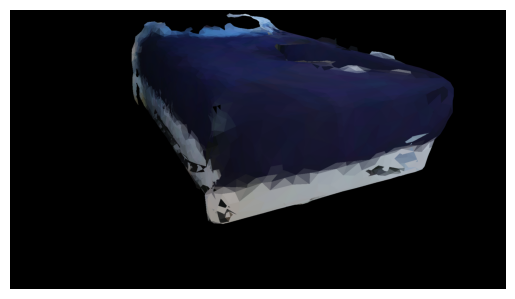

In [54]:
def draw_triangle(img, vertices, color):
    cv2.fillConvexPoly(img, vertices, color)

image_height, image_width = 1080, 1920
image = np.zeros((image_height, image_width, 3), dtype=np.uint8)

for face in object_mesh.triangles:
    pts_2d = np.array(object_vertices_2d[face], dtype=np.int32)
    vertex_colors = np.asarray(object_mesh.vertex_colors)[face] * 255
    average_color_rgb = np.mean(vertex_colors, axis=0)
    average_color_rgb_int = np.array(average_color_rgb, dtype=np.uint8)
    color_bgr = (int(average_color_rgb_int[2]), int(average_color_rgb_int[1]), int(average_color_rgb_int[0]))
    draw_triangle(image, pts_2d, color_bgr)

plt.figure()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()